# Analyze 8K Results Relevance

In [1]:
#setup
%matplotlib inline
import pandas as pd
import numpy as np
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import rcParams
import json
import time
import random
import requests
import re
import os
import nltk
import string
import tqdm
import warnings
import seaborn as sns; sns.set()
from collections import defaultdict
from operator import itemgetter
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

warnings.filterwarnings('ignore')

nlp = spacy.load("en_core_web_sm")

rcParams['figure.figsize'] = (8, 6)
# rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = 'white'
# rcParams['font.size'] = 14
# rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [2]:
# read data
file_dir = "/Users/ivette/Work/tech-backends/trust_repository/classifier/data_handlers/data/"
df = pd.read_csv(file_dir+"results_hashtags.csv")
print(df.shape)

(8168, 14)


In [3]:
len(df.fact_check_source.unique())

203

In [4]:
df.iloc[0]

author_username                                         jagjitsingh262
url                  https://www.tiktok.com/@jagjitsingh262/video/6...
platform                                                        tiktok
last_seen                                   2020-08-07T04:22:05.740390
snippet              Respect doctors they too have family 😒 #HandWa...
search_term                                                        NaN
source                                          fact_check_as_hashtags
create_date                                        2020-04-03T10:21:39
stats                {'diggCount': 4800000, 'shareCount': 35800, 'p...
hashtags             ['handwashchallenge', 'gharbaithoindia', 'safe...
music_info           {'musicId': '6674930692322888454', 'musicName'...
status                                                           alive
fact_check_source    https://apnews.com/e4d704855a94317b71698a10c67...
title_keywords              ['coronavirus', 'pandemic', 'safe', 'gym']
Name: 

In [5]:
with open(file_dir+"source_keywords.json", "r") as f:
    source_keywords = json.loads(f.read())
    
print(len(source_keywords))
print(source_keywords[0])

979
{'source': 'https://apnews.com/e4d704855a94317b71698a10c675e3fe', 'language': 'en', 'title_keywords': 'safe go gym coronavirus pandemic', 'content_keywords': ['safe', 'go', 'gym', 'coronavirus', 'pandemic', 's', 'safer', 'dr', 'marybeth', 'sexton', 'assistant', 'professor', 'infectious', 'disease', 'emory', 'university']}


## Narrow down to videos contain 3+ original keywords

In [6]:
source_keywords_by_url = {item["source"]: item for item in source_keywords}

def find_source(url):
    return source_keywords_by_url[url]

In [7]:
# match with source_keywords

count_title_kw = []
count_content_kw = []
title_kw = []
content_kw = []

for i, row in df.iterrows():
    source = find_source(row["fact_check_source"])
    
    title_keywords = source["title_keywords"]
    if isinstance(title_keywords, str):
        title_keywords = title_keywords.split()
    
    content_keywords = source["content_keywords"]
    
    count_title_kw.append(sum([word.lower() in row["snippet"].lower() for word in title_keywords]))
    count_content_kw.append(sum([word.lower() in row["snippet"].lower() for word in content_keywords]))
    title_kw.append(title_keywords)
    content_kw.append(content_keywords)


In [8]:
df["count_title_keywords"] = count_title_kw
df["count_content_keywords"] = count_content_kw
df["title_keywords_original"] = title_kw
df["content_keywords_original"] = content_kw
df.head()

,author_username,url,platform,last_seen,snippet,search_term,source,create_date,stats,hashtags,music_info,status,fact_check_source,title_keywords,count_title_keywords,count_content_keywords,title_keywords_original,content_keywords_original
0,jagjitsingh262,https://www.tiktok.com/@jagjitsingh262/video/6...,tiktok,2020-08-07T04:22:05.740390,Respect doctors they too have family 😒 #HandWa...,NaN,fact_check_as_hashtags,2020-04-03T10:21:39,"{'diggCount': 4800000, 'shareCount': 35800, 'p...","['handwashchallenge', 'gharbaithoindia', 'safe...","{'musicId': '6674930692322888454', 'musicName'...",alive,https://apnews.com/e4d704855a94317b71698a10c67...,"['coronavirus', 'pandemic', 'safe', 'gym']",2,3,"[safe, go, gym, coronavirus, pandemic]","[safe, go, gym, coronavirus, pandemic, s, safe..."
1,thesnobcats,https://www.tiktok.com/@thesnobcats/video/6807...,tiktok,2020-08-07T04:22:05.740402,"#gharbaithoindia Stay home, Stay safe! lnspire...",NaN,fact_check_as_hashtags,2020-03-24T06:07:56,"{'diggCount': 4700000, 'shareCount': 235600, '...","['', 'gharbaithoindia', 'stayhome', 'staysafe'...","{'musicId': '6806684853996620546', 'musicName'...",alive,https://apnews.com/e4d704855a94317b71698a10c67...,"['coronavirus', 'pandemic', 'safe', 'gym']",2,3,"[safe, go, gym, coronavirus, pandemic]","[safe, go, gym, coronavirus, pandemic, s, safe..."
2,unicefindia,https://www.tiktok.com/@unicefindia/video/6806...,tiktok,2020-08-07T04:22:05.740454,आपके लिए अमिताभ बच्चन का एक संदेश। #covid19 #c...,NaN,fact_check_as_hashtags,2020-03-20T07:39:11,"{'diggCount': 4400000, 'shareCount': 120300, '...","['covid19', 'coronavirus', 'safehands', 'coron...","{'musicId': '6806237833909586690', 'musicName'...",alive,https://apnews.com/e4d704855a94317b71698a10c67...,"['coronavirus', 'pandemic', 'safe', 'gym']",2,3,"[safe, go, gym, coronavirus, pandemic]","[safe, go, gym, coronavirus, pandemic, s, safe..."
3,aristotle_gold,https://www.tiktok.com/@aristotle_gold/video/6...,tiktok,2020-08-07T04:22:05.740624,Just send love and light and everyone be safe ...,NaN,fact_check_as_hashtags,2020-03-18T13:39:09,"{'diggCount': 3600000, 'shareCount': 221500, '...","['coronavirus', 'covid19', 'foryou', 'foryoupa...","{'musicId': '6805583323637844742', 'musicName'...",alive,https://apnews.com/e4d704855a94317b71698a10c67...,"['coronavirus', 'pandemic', 'safe', 'gym']",2,3,"[safe, go, gym, coronavirus, pandemic]","[safe, go, gym, coronavirus, pandemic, s, safe..."
4,tayamarquis,https://www.tiktok.com/@tayamarquis/video/6805...,tiktok,2020-08-07T04:22:05.740787,So please stop buying out all their groceries ...,NaN,fact_check_as_hashtags,2020-03-17T13:40:01,"{'diggCount': 3100000, 'shareCount': 27000, 'p...","['coronavirus', 'covid19', 'quarantine', 'stay...","{'musicId': '6787078702082607878', 'musicName'...",alive,https://apnews.com/e4d704855a94317b71698a10c67...,"['coronavirus', 'pandemic', 'safe', 'gym']",2,3,"[safe, go, gym, coronavirus, pandemic]","[safe, go, gym, coronavirus, pandemic, s, safe..."


In [9]:
df.count_title_keywords.value_counts()

2    6456
3    1030
1     520
4     115
5      29
7      16
8       1
0       1
Name: count_title_keywords, dtype: int64

In [10]:
df.count_content_keywords.value_counts()

2    2880
1    2687
0    1534
3     882
4     147
5      35
6       3
Name: count_content_keywords, dtype: int64

In [11]:
# videos with <=1 title keywords
# usually snippet was matched to plurao forms of of nounrs
# e.g. reopenings and reopening, stokes and stoke

for i, row in df[df.count_title_keywords<=1].iloc[:30].iterrows():
    print(row["snippet"])
    print(row["title_keywords"])
    print(row["title_keywords_original"], "\n")

What Teachers Really Want To Say! #reopening #reopeningschool #cdc #cdcguidelines #teacher #teachertiktoker #fyp #over40club
['reopening', 'reopenings', 'safe', 'hotel']
['safe', 'stay', 'hotel', 'reopenings', 'get', 'underway'] 

“they wanna keep us safe” 🤡  #LetsFaceIt  #covid #fyp #college #TwoOptions #school #SummerProject #reopening #coronatime
['reopening', 'reopenings', 'safe', 'hotel']
['safe', 'stay', 'hotel', 'reopenings', 'get', 'underway'] 

And that’s on New York #reopening next week #funny #comedy #SafeguardSplash #disney #phineasandferb #fun #actor #quarantineisover #obsessedwithit
['reopening', 'reopenings', 'safe', 'hotel']
['safe', 'stay', 'hotel', 'reopenings', 'get', 'underway'] 

world cup#stokes##cricket ## ##indiachallenge ##stokecity
['racial', 'stokes', 'misinformation', 'tension', 'protest', 'minneapolis', 'stoke']
['minneapolis', 'protest', 'misinformation', 'stokes', 'racial', 'tension'] 

My lovely #rowdy baby #Rx 100 too #stokes #yamaha 🔥👍
['racial', 'stok

In [12]:
for source, group in df[df.count_title_keywords>=3].iloc[:30].groupby("fact_check_source"):
    print("\n", source, "\n")
    
    for i, row in group.iterrows():
        print(row["snippet"])
        print(row["title_keywords"])
        print(row["title_keywords_original"], "\n")


 https://apnews.com/02b0c7bb496a21d9e09abb1d01cecf1a 

& he started w/ millions.  #dumptrump #biden2020 #liberal #voteblue #democrat #economy #money #reopening #trump2020 #trump #politics #vote #fyp
['trump', 'economy', 'biden', 'virus', 'fact']
['trump', 'bending', 'fact', 'virus', 'biden', 'economy'] 

#viral #tiktok #tiktokban #trump #america #americafirst #trump2020 #fyp #conservative #republican #economy #stocks #wallstreet #biden #bernie
['trump', 'economy', 'biden', 'virus', 'fact']
['trump', 'bending', 'fact', 'virus', 'biden', 'economy'] 

Eat The Rich #greenscreen #politics #economy #coronavirus #jeffbezos #trump2020 #bernie2020 #biden2020 #liberal #conservative
['trump', 'economy', 'biden', 'virus', 'fact']
['trump', 'bending', 'fact', 'virus', 'biden', 'economy'] 

Facts right? #duet with @chrisrunsthis #Trump #economy #theworst
['trump', 'economy', 'biden', 'virus', 'fact']
['trump', 'bending', 'fact', 'virus', 'biden', 'economy'] 

Maybe we should call it the trump virus

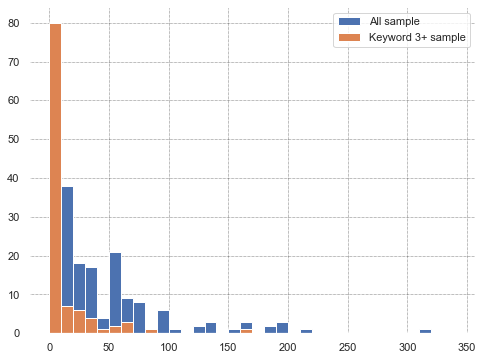

In [13]:
df_plus3 = df[df.count_title_keywords>=3]
plt.hist(df.groupby("fact_check_source").url.count(), bins=list(range(0, 350, 10)), label="All sample")
plt.hist(df_plus3.groupby("fact_check_source").url.count(), bins=list(range(0, 350, 10)), label="Keyword 3+ sample")
plt.gca().grid(linestyle='dotted', linewidth='0.5', color='black')
plt.legend()

In [14]:
df_plus3.shape

(1191, 18)

In [15]:
df_plus3.to_csv(file_dir+"keyword_count_3+.csv", index=False)

## A random sample of 250 videos

In [16]:
# add similarity scores
matched = pd.read_csv(file_dir+"similarity_xiaolin_output1.csv")
matched["stats"] = matched.stats.map(lambda v: eval(v))
matched["title_keywords"] = matched.title_keywords_original.map(lambda l: eval(l))
matched["hashtags"] = matched.hashtags.map(lambda l: eval(l))
matched.iloc[0]

Unnamed: 0                                                                   0
author_username                                                    kotomaxkami
url                          https://www.tiktok.com/@kotomaxkami/video/6848...
platform                                                                tiktok
last_seen                                           2020-08-07T04:28:03.814027
snippet                      #wayfairchildtrafficking #Wayfairtrafficing #w...
search_term                                                                NaN
source                                                  fact_check_as_hashtags
create_date                                                2020-07-12T03:38:25
stats                        {'diggCount': 50400, 'shareCount': 1974, 'play...
hashtags                     [wayfairchildtrafficking, wayfairtrafficing, w...
music_info                   {'musicId': '6848494962774936326', 'musicName'...
status                                              

In [17]:
matched.shape

(253, 22)

In [18]:
matched = matched.drop_duplicates("url")

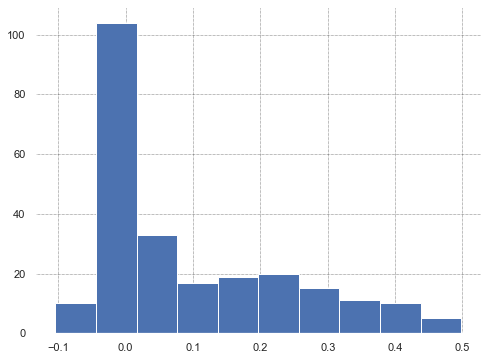

In [19]:
matched.score.hist()
plt.gca().grid(linestyle='dotted', linewidth='0.5', color='black')

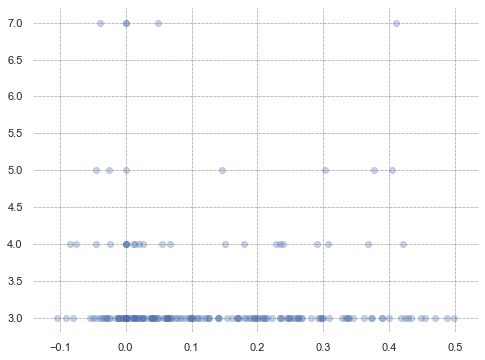

In [20]:
plt.scatter(matched.score, matched.count_title_keywords, alpha=0.3)
plt.gca().grid(linestyle='dotted', linewidth='0.5', color='black')

In [21]:
matched.iloc[1].stats.keys()

dict_keys(['diggCount', 'shareCount', 'playCount', 'commentCount', 'length', 'word_counts', 'insult_summary', 'insult_max', 'threat_summary', 'threat_max', 'flirtation_summary', 'flirtation_max', 'profanity_summary', 'profanity_max', 'severe_toxicity_summary', 'severe_toxicity_max', 'toxicity_summary', 'toxicity_max', 'identity_attack_summary', 'identity_attack_max', 'sexually_explicit_summary', 'sexually_explicit_max', 'neg', 'neu', 'pos', 'compound'])

In [22]:
keys = list(matched.iloc[1].stats.keys())

for key in list(keys):
    matched[key] = matched.stats.map(lambda d: d.get(key))

In [23]:
matched["num_title_keywords"] = matched.title_keywords_original.map(lambda l: len(l))
matched["num_hashtags"] = matched.hashtags.map(lambda l: len(l))
metrics = matched[keys + ["num_title_keywords", "num_hashtags", "score"]]
metrics.corr()

,diggCount,shareCount,playCount,commentCount,length,word_counts,insult_summary,insult_max,threat_summary,threat_max,...,identity_attack_max,sexually_explicit_summary,sexually_explicit_max,neg,neu,pos,compound,num_title_keywords,num_hashtags,score
diggCount,1.000000,0.561280,0.843405,0.481361,-0.064712,-0.046992,-0.149470,-0.149470,-0.143036,-0.143036,...,-0.119525,-0.086707,-0.086707,-0.163226,0.162279,-0.068438,0.085869,-0.153288,-0.017121,-0.149872
shareCount,0.561280,1.000000,0.432489,0.637240,-0.070592,-0.075557,-0.090241,-0.090241,-0.077843,-0.077843,...,-0.067221,-0.036560,-0.036560,-0.098967,0.096310,-0.038995,0.002583,-0.102380,-0.014306,-0.129108
playCount,0.843405,0.432489,1.000000,0.267210,-0.113775,-0.104568,-0.139728,-0.139728,-0.150449,-0.150449,...,-0.132288,-0.071543,-0.071543,-0.140043,0.175563,-0.101844,0.025312,-0.133607,0.003381,-0.158311
commentCount,0.481361,0.637240,0.267210,1.000000,-0.040086,-0.036575,-0.093509,-0.093509,-0.083184,-0.083184,...,-0.050684,-0.064725,-0.064725,-0.101241,0.072001,-0.008426,0.055286,-0.099503,-0.009610,-0.112948
length,-0.064712,-0.070592,-0.113775,-0.040086,1.000000,0.993979,0.308336,0.308336,0.352015,0.352015,...,0.418865,0.277484,0.277484,0.080326,-0.050343,-0.001322,0.107449,-0.084640,-0.080798,0.691385
word_counts,-0.046992,-0.075557,-0.104568,-0.036575,0.993979,1.000000,0.311247,0.311247,0.346918,0.346918,...,0.403843,0.273516,0.273516,0.071157,-0.058100,0.014843,0.142681,-0.112826,-0.085860,0.658218
insult_summary,-0.149470,-0.090241,-0.139728,-0.093509,0.308336,0.311247,1.000000,1.000000,0.674756,0.674756,...,0.756386,0.634834,0.634834,0.426489,-0.288242,0.018532,-0.233650,0.058191,0.022912,0.270981
insult_max,-0.149470,-0.090241,-0.139728,-0.093509,0.308336,0.311247,1.000000,1.000000,0.674756,0.674756,...,0.756386,0.634834,0.634834,0.426489,-0.288242,0.018532,-0.233650,0.058191,0.022912,0.270981
threat_summary,-0.143036,-0.077843,-0.150449,-0.083184,0.352015,0.346918,0.674756,0.674756,1.000000,1.000000,...,0.657292,0.485610,0.485610,0.332350,-0.139228,-0.086958,-0.301236,-0.011652,-0.061596,0.360602
threat_max,-0.143036,-0.077843,-0.150449,-0.083184,0.352015,0.346918,0.674756,0.674756,1.000000,1.000000,...,0.657292,0.485610,0.485610,0.332350,-0.139228,-0.086958,-0.301236,-0.011652,-0.061596,0.360602


In [24]:
df = metrics.corr()
df = df.apply(lambda val: round(val, 2))

In [25]:
max(matched.score), min(matched.score)

(0.4981730580329895, -0.10435369610786438)

In [26]:
matched["no_text"] = matched.transcription_text.map(lambda text: pd.isnull(text) or len(text)==0)
matched.no_text.sum()

74

In [27]:
N = sum(matched.no_text==False)

cutoffs = []
matched_count = []

for cutoff in range(20, 60, 5):
    cutoff = cutoff/100
    cutoffs.append(cutoff)
    matched_count.append(matched[matched.score >= cutoff].shape[0])
    
relevance_df = pd.DataFrame({"cutoff": cutoffs, "count_above_cutoff": matched_count})
relevance_df["pct_above_cutoff"] = relevance_df.count_above_cutoff.map(lambda val: round(val/N, 3))
relevance_df

,cutoff,count_above_cutoff,pct_above_cutoff
0,0.20,60,0.353
1,0.25,43,0.253
2,0.30,29,0.171
3,0.35,20,0.118
4,0.40,13,0.076
5,0.45,4,0.024
6,0.50,0,0.000
7,0.55,0,0.000


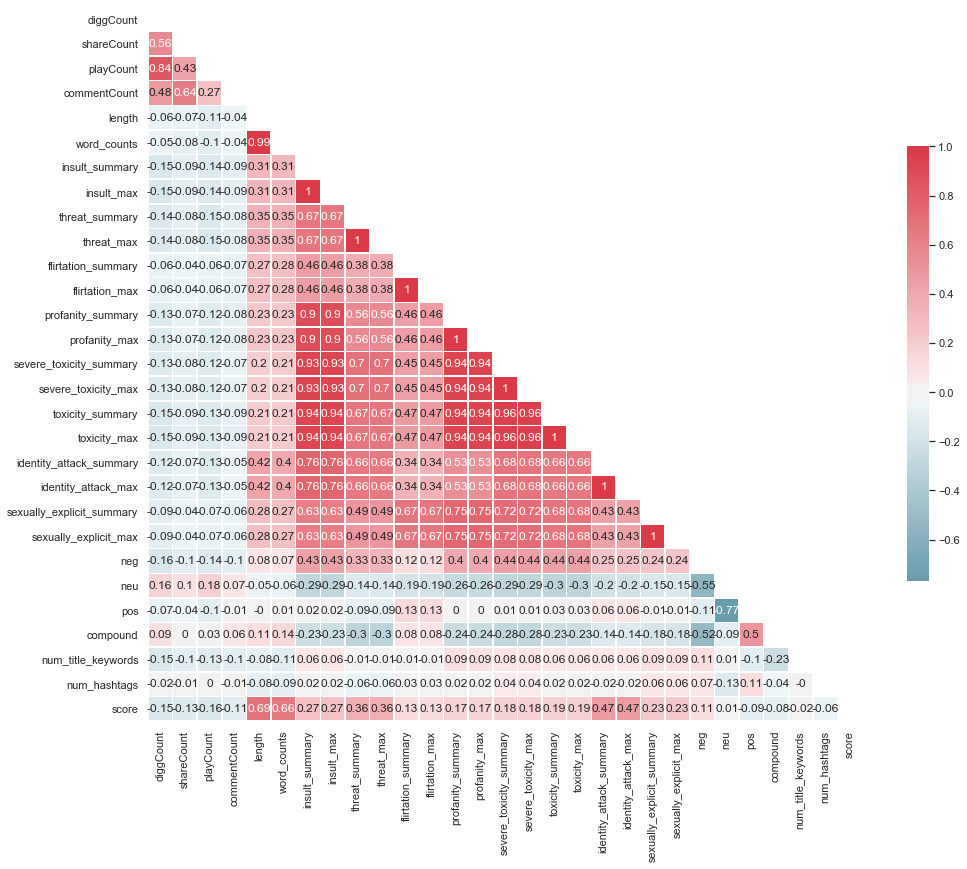

In [28]:
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(df, mask=mask, cmap=sns.diverging_palette(220, 10, as_cmap=True), # sns.color_palette("Blues") 
                       vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)


In [29]:
# video related to wayfair story

for i, row in matched[matched.fact_check_source=="https://apnews.com/9d54570ebba5e406667c38cb29522ec6"].iterrows():
    print(round(row["score"], 3), row["url"])

0.0 https://www.tiktok.com/@kotomaxkami/video/6848495013622467845
0.449 https://www.tiktok.com/@reinasingss/video/6849700939977231622
0.04 https://www.tiktok.com/@kandisespo/video/6850238660290415877


In [30]:
for source, group in matched[((matched.score <=0.1))].groupby("fact_check_source"):
    print(source, "\n")
    
    for i, row in group.iterrows():
        print(round(row["score"], 3), row["url"])
        print(row["snippet"], "\n")

https://apnews.com/203dcf15c580a0c6a5026b68c51b6b2f 

-0.024 https://www.tiktok.com/@marl33andm3/video/6848321762128661765
Blow this up y’all! #fyp #genz #FashionFavorites #ColorCustomizer #TheOldGuard #foryou #trump #protest #foryou #biden2020 #liberal #rally 

https://apnews.com/9d54570ebba5e406667c38cb29522ec6 

0.0 https://www.tiktok.com/@kotomaxkami/video/6848495013622467845
#wayfairchildtrafficking #Wayfairtrafficing #wayfairscandal #wayfair #anime #memesdaily #Hxh #ColorCustomizer #FashionFavorites #NBA #basketball 

0.04 https://www.tiktok.com/@kandisespo/video/6850238660290415877
this is no joke😔 #trump2020 #trump #trumptrain #maga #kag #corrupt #childtrafficking #wayfair #biden #foryoupage #trumpsupporter #clinton #usa #help 

https://apnews.com/afs:Content:8993962141 

-0.004 https://www.tiktok.com/@pride.month/video/6831396543505992965
how many black people need to die before we do SOMETHING. #nojusticenopeace #sayhisname #georgefloyd #minneapolis #blacklivesmatter 

https: